In [1]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from transformers import ViTModel, ViTImageProcessor
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric.nn import PointNetConv
from torch_geometric.data import Data
from torch_geometric.nn.pool import knn_graph
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

nusc = NuScenes(version='v1.0-mini', dataroot='../../3Dperc_p2/nuscenes', verbose=True)


Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.418 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
# Definisci l'encoder PointNet per i dati LiDAR
class PointNetEncoder(torch.nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = PointNetConv(local_nn=torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256)
        ))
        self.conv2 = PointNetConv(local_nn=torch.nn.Sequential(
            torch.nn.Linear(256 + 3, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024)
        ))
        self.fc = torch.nn.Linear(1024, 256)

    def forward(self, pos, edge_index):
        x = F.relu(self.conv1(None, pos, edge_index))
        x = F.relu(self.conv2(x, pos, edge_index))
        x = torch.max(x, dim=0)[0]
        x = self.fc(x)
        x = x.view(1, -1)
        return x

In [ ]:
# Funzione per processare un singolo sample e ottenere embedding
def process_sample_with_embeddings(sample, image_processor, vision_model, lidar_encoder, fusion_layer):
    try:
        # Estrai i dati dell'immagine
        camera_token = sample['data']['CAM_FRONT']
        image_path = nusc.get_sample_data_path(camera_token)
        image = Image.open(image_path).convert('RGB') #carica immagine
        image_tensor = image_processor(images=image, return_tensors="pt")["pixel_values"] #converte in input adatto a ViT

        # Estrai i dati LiDAR
        lidar_token = sample['data']['LIDAR_TOP']
        lidar_path = nusc.get_sample_data_path(lidar_token)
        lidar_points = LidarPointCloud.from_file(lidar_path) #carica point cloud
        lidar_tensor = torch.tensor(lidar_points.points[:3, :].T, dtype=torch.float32)

        # Calcola gli embedding dell'immagine
        vision_outputs = vision_model(pixel_values=image_tensor)
        image_embedding = vision_outputs.last_hidden_state[:, 0, :] # 0 = il primo token nella sequenza, cioè [CLS] = token per embadding immagine

        # Calcola gli embedding LiDAR
        edge_index = knn_graph(lidar_tensor, k=22) 
        lidar_embedding = lidar_encoder(lidar_tensor, edge_index)

        # Fusione degli embedding
        fused_embedding = fusion_layer(torch.cat((image_embedding, lidar_embedding), dim=1))

        # Ritorna embedding fusi, LiDAR embedding e Camera embedding
        return fused_embedding.detach().numpy(), lidar_embedding.detach().numpy(), image_embedding.detach().numpy()

    except Exception as e:
        print(f"Errore nel processare il sample: {e}")
        return None, None, None


In [4]:
class Classifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),  
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),        
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes) 
        )

    def forward(self, x):
        x = self.fc(x)
        return x  # Logits in output


In [ ]:
# Prepara il modello Vision Transformer e il processore di immagini
vision_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Inizializza l'encoder LiDAR e il livello di fusione
lidar_encoder = PointNetEncoder()
fusion_layer = torch.nn.Sequential(
    torch.nn.Linear(vision_model.config.hidden_size + 256, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 128) #embadding finale 
)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Inizializza un set per raccogliere tutte le categorie
all_categories = set()

# Liste per memorizzare gli embeddings e le etichette
fused_embeddings = []
lidar_embeddings = []
camera_embeddings = []
labels_list = []

for sample in tqdm(nusc.sample):
    fused_embedding, lidar_embedding, image_embedding = process_sample_with_embeddings(sample, image_processor, vision_model, lidar_encoder, fusion_layer)
    if fused_embedding is not None:
        fused_embeddings.append(fused_embedding)
        lidar_embeddings.append(lidar_embedding)
        camera_embeddings.append(image_embedding)

        # Estrai le etichette
        anns = sample['anns']
        sample_categories = set()
        for ann_token in anns:
            ann_record = nusc.get('sample_annotation', ann_token)
            category_name = ann_record['category_name']
            sample_categories.add(category_name)
            all_categories.add(category_name)
        labels_list.append(sample_categories)
        
        # Passa al prossimo sample
        sample_token = sample['next']

# Mappa le categorie a indici numerici
category_to_index = {category: idx for idx, category in enumerate(sorted(all_categories))}
index_to_category = {idx: category for category, idx in category_to_index.items()}
num_categories = len(category_to_index)

print(num_categories)

# Crea i vettori di etichette multi-hot
label_vectors = []
for sample_categories in labels_list:
    label_vector = np.zeros(num_categories, dtype=np.float32)
    for category in sample_categories:
        idx = category_to_index[category]
        label_vector[idx] = 1.0
    label_vectors.append(label_vector)

# Converte gli embedding fusi in un array NumPy
fused_embeddings = np.concatenate(fused_embeddings, axis=0)  # Forma: (num_samples, 128)
label_vectors = np.array(label_vectors)  # Forma: (num_samples, num_categories)
lidar_embeddings = np.concatenate(lidar_embeddings, axis=0)  # Forma: (num_samples, 256)
camera_embeddings = np.concatenate(camera_embeddings, axis=0)  # Forma: (num_samples, vision_model.config.hidden_size)

print("Shape finale degli embedding fusi:", fused_embeddings.shape)
print("Shape delle etichette:", label_vectors.shape)


100%|██████████| 404/404 [1:15:00<00:00, 11.14s/it]


18
Shape finale degli embedding fusi: (404, 128)
Shape delle etichette: (404, 18)


In [7]:
# Suddivisione dei dati in training e test set

X_train, X_test, y_train, y_test = train_test_split(fused_embeddings, label_vectors, test_size=0.2, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Prepara i tensori PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)


In [8]:
# Split per LiDAR embeddings
X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar = train_test_split( lidar_embeddings, label_vectors, test_size=0.2, random_state=42 )
X_train_lidar, X_validation_lidar, y_train_lidar, y_validation_lidar = train_test_split(X_train_lidar, y_train_lidar, test_size=0.2, random_state=42 )

# Split per Camera embeddings
X_train_camera, X_test_camera, y_train_camera, y_test_camera = train_test_split( camera_embeddings, label_vectors, test_size=0.2, random_state=42 )
X_train_camera, X_validation_camera, y_train_camera, y_validation_camera = train_test_split(X_train_camera, y_train_camera, test_size=0.2, random_state=42 )

In [9]:
# Crea i DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)

batch_size = 32 #piccolo per il dataset 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

# Prepara i tensori PyTorch per LiDAR embeddings
X_train_tensor_lidar = torch.tensor(X_train_lidar, dtype=torch.float32)
y_train_tensor_lidar = torch.tensor(y_train_lidar, dtype=torch.float32)
X_validation_tensor_lidar = torch.tensor(X_validation_lidar, dtype=torch.float32)
y_validation_tensor_lidar = torch.tensor(y_validation_lidar, dtype=torch.float32)
X_test_tensor_lidar = torch.tensor(X_test_lidar, dtype=torch.float32)
y_test_tensor_lidar = torch.tensor(y_test_lidar, dtype=torch.float32)

# Dataset e DataLoader
train_dataset_lidar = TensorDataset(X_train_tensor_lidar, y_train_tensor_lidar)
validation_dataset_lidar = TensorDataset(X_validation_tensor_lidar, y_validation_tensor_lidar)
test_dataset_lidar = TensorDataset(X_test_tensor_lidar, y_test_tensor_lidar)

batch_size = 32
train_loader_lidar = DataLoader(train_dataset_lidar, batch_size=batch_size, shuffle=True)
validation_loader_lidar = DataLoader(validation_dataset_lidar, batch_size=batch_size)

# Prepara i tensori PyTorch per Camera embeddings
X_train_tensor_camera = torch.tensor(X_train_camera, dtype=torch.float32)
y_train_tensor_camera = torch.tensor(y_train_camera, dtype=torch.float32)
X_validation_tensor_camera = torch.tensor(X_validation_camera, dtype=torch.float32)
y_validation_tensor_camera = torch.tensor(y_validation_camera, dtype=torch.float32)
X_test_tensor_camera = torch.tensor(X_test_camera, dtype=torch.float32)
y_test_tensor_camera = torch.tensor(y_test_camera, dtype=torch.float32)

# Dataset e DataLoader
train_dataset_camera = TensorDataset(X_train_tensor_camera, y_train_tensor_camera)
validation_dataset_camera = TensorDataset(X_validation_tensor_camera, y_validation_tensor_camera)
test_dataset_camera = TensorDataset(X_test_tensor_camera, y_test_tensor_camera)

train_loader_camera = DataLoader(train_dataset_camera, batch_size=batch_size, shuffle=True)
validation_loader_camera = DataLoader(validation_dataset_camera, batch_size=batch_size)





Epoch [1/75], Train Loss: 0.6700, Val Loss: 0.6223
Epoch [2/75], Train Loss: 0.5591, Val Loss: 0.4824
Epoch [3/75], Train Loss: 0.4515, Val Loss: 0.4560
Epoch [4/75], Train Loss: 0.4258, Val Loss: 0.4304
Epoch [5/75], Train Loss: 0.4114, Val Loss: 0.4210
Epoch [6/75], Train Loss: 0.3964, Val Loss: 0.4103
Epoch [7/75], Train Loss: 0.3807, Val Loss: 0.3913
Epoch [8/75], Train Loss: 0.3639, Val Loss: 0.3747
Epoch [9/75], Train Loss: 0.3471, Val Loss: 0.3559
Epoch [10/75], Train Loss: 0.3322, Val Loss: 0.3445
Epoch [11/75], Train Loss: 0.3204, Val Loss: 0.3352
Epoch [12/75], Train Loss: 0.3070, Val Loss: 0.3209
Epoch [13/75], Train Loss: 0.2994, Val Loss: 0.3110
Epoch [14/75], Train Loss: 0.2859, Val Loss: 0.3014
Epoch [15/75], Train Loss: 0.2749, Val Loss: 0.2879
Epoch [16/75], Train Loss: 0.2640, Val Loss: 0.2777
Epoch [17/75], Train Loss: 0.2540, Val Loss: 0.2708
Epoch [18/75], Train Loss: 0.2460, Val Loss: 0.2605
Epoch [19/75], Train Loss: 0.2359, Val Loss: 0.2519
Epoch [20/75], Train 

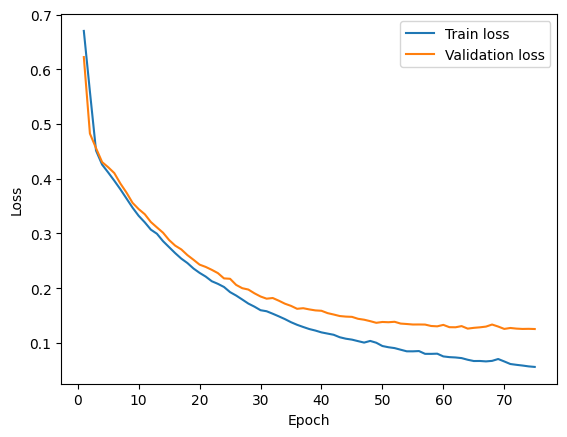

In [10]:
# Inizializza il modello, la funzione di perdita e l'ottimizzatore
input_size = fused_embeddings.shape[1]
num_classes = num_categories

model = Classifier(input_size, num_classes)

criterion = torch.nn.BCEWithLogitsLoss()  #binary cross entropy per la classificazione multi-etichetta
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
validation_losses = []

# Fase di addestramento
num_epochs = 75

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad() #reset
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward() #calcolo gradiente
        optimizer.step() #aggiornamento pesi
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_dataset)

    train_losses.append(avg_loss)  # Salva la perdita di training

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            val_loss = criterion(outputs, batch_y)
            total_val_loss += val_loss.item() * batch_X.size(0)
    avg_val_loss = total_val_loss / len(test_dataset)
    validation_losses.append(avg_val_loss)  # Salva la perdita di validazione/test

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation loss')
plt.legend()
plt.show()

In [11]:
# Fase di predizione e valutazione

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(batch_y.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Binarizza le predizioni con soglia 0.5
all_preds_binary = (all_preds >= 0.5).astype(int)

# Calcola l'F1 score
f1 = f1_score(all_targets, all_preds_binary, average='micro')
print(f"Test F1 Score: {f1:.4f}")

Test F1 Score: 0.9234


Epoch [1/75], Train Loss: 0.6247, Val Loss: 0.5293
Epoch [2/75], Train Loss: 0.4761, Val Loss: 0.4821
Epoch [3/75], Train Loss: 0.4400, Val Loss: 0.4489
Epoch [4/75], Train Loss: 0.4319, Val Loss: 0.4511
Epoch [5/75], Train Loss: 0.4291, Val Loss: 0.4522
Epoch [6/75], Train Loss: 0.4269, Val Loss: 0.4466
Epoch [7/75], Train Loss: 0.4288, Val Loss: 0.4432
Epoch [8/75], Train Loss: 0.4273, Val Loss: 0.4514
Epoch [9/75], Train Loss: 0.4241, Val Loss: 0.4437
Epoch [10/75], Train Loss: 0.4283, Val Loss: 0.4398
Epoch [11/75], Train Loss: 0.4218, Val Loss: 0.4419
Epoch [12/75], Train Loss: 0.4200, Val Loss: 0.4401
Epoch [13/75], Train Loss: 0.4171, Val Loss: 0.4316
Epoch [14/75], Train Loss: 0.4166, Val Loss: 0.4289
Epoch [15/75], Train Loss: 0.4105, Val Loss: 0.4306
Epoch [16/75], Train Loss: 0.4067, Val Loss: 0.4216
Epoch [17/75], Train Loss: 0.4061, Val Loss: 0.4188
Epoch [18/75], Train Loss: 0.4024, Val Loss: 0.4181
Epoch [19/75], Train Loss: 0.3988, Val Loss: 0.4197
Epoch [20/75], Train 

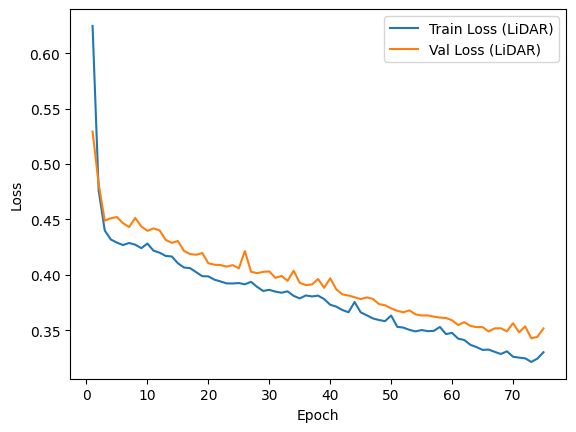

In [12]:
# Modello, ottimizzatore e funzione di perdita per LiDAR embeddings
input_size_lidar = lidar_embeddings.shape[1]
num_classes = label_vectors.shape[1]

model_lidar = Classifier(input_size_lidar, num_classes)
criterion = torch.nn.BCEWithLogitsLoss()  # Multi-label classification
optimizer = torch.optim.Adam(model_lidar.parameters(), lr=1e-3)

# Training e Validazione
num_epochs = 75
train_losses_lidar, val_losses_lidar = [], []

for epoch in range(num_epochs):
    model_lidar.train()
    total_loss = 0
    for batch_X, batch_y in train_loader_lidar:
        optimizer.zero_grad()
        outputs = model_lidar(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_dataset_lidar)
    train_losses_lidar.append(avg_loss)

    # Validazione
    model_lidar.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in validation_loader_lidar:
            outputs = model_lidar(batch_X)
            val_loss = criterion(outputs, batch_y)
            total_val_loss += val_loss.item() * batch_X.size(0)
    avg_val_loss = total_val_loss / len(validation_dataset_lidar)
    val_losses_lidar.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot delle perdite
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses_lidar, label='Train Loss (LiDAR)')
plt.plot(range(1, num_epochs + 1), val_losses_lidar, label='Val Loss (LiDAR)')
plt.legend()
plt.show()


Epoch [1/75], Train Loss: 0.5403, Val Loss: 0.4053
Epoch [2/75], Train Loss: 0.3559, Val Loss: 0.3216
Epoch [3/75], Train Loss: 0.2779, Val Loss: 0.2785
Epoch [4/75], Train Loss: 0.2375, Val Loss: 0.2264
Epoch [5/75], Train Loss: 0.1951, Val Loss: 0.1968
Epoch [6/75], Train Loss: 0.1602, Val Loss: 0.1680
Epoch [7/75], Train Loss: 0.1313, Val Loss: 0.1384
Epoch [8/75], Train Loss: 0.1128, Val Loss: 0.1352
Epoch [9/75], Train Loss: 0.1040, Val Loss: 0.1112
Epoch [10/75], Train Loss: 0.0882, Val Loss: 0.1054
Epoch [11/75], Train Loss: 0.0778, Val Loss: 0.0939
Epoch [12/75], Train Loss: 0.0687, Val Loss: 0.0840
Epoch [13/75], Train Loss: 0.0615, Val Loss: 0.0779
Epoch [14/75], Train Loss: 0.0581, Val Loss: 0.0767
Epoch [15/75], Train Loss: 0.0505, Val Loss: 0.0845
Epoch [16/75], Train Loss: 0.0520, Val Loss: 0.0842
Epoch [17/75], Train Loss: 0.0544, Val Loss: 0.0819
Epoch [18/75], Train Loss: 0.0404, Val Loss: 0.0635
Epoch [19/75], Train Loss: 0.0339, Val Loss: 0.0723
Epoch [20/75], Train 

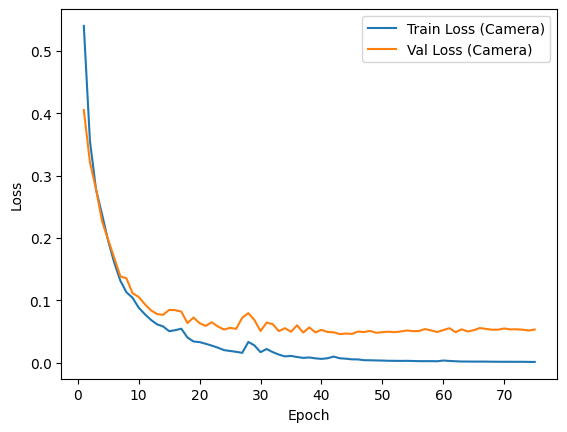

In [13]:
# Modello, ottimizzatore e funzione di perdita per Camera embeddings
input_size_camera = camera_embeddings.shape[1]

model_camera = Classifier(input_size_camera, num_classes)
optimizer_camera = torch.optim.Adam(model_camera.parameters(), lr=1e-3)

# Training e Validazione
train_losses_camera, val_losses_camera = [], []

num_epochs = 75

for epoch in range(num_epochs):
    model_camera.train()
    total_loss = 0
    for batch_X, batch_y in train_loader_camera:
        optimizer_camera.zero_grad()
        outputs = model_camera(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_camera.step()
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_dataset_camera)
    train_losses_camera.append(avg_loss)

    # Validazione
    model_camera.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in validation_loader_camera:
            outputs = model_camera(batch_X)
            val_loss = criterion(outputs, batch_y)
            total_val_loss += val_loss.item() * batch_X.size(0)
    avg_val_loss = total_val_loss / len(validation_dataset_camera)
    val_losses_camera.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot delle perdite
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses_camera, label='Train Loss (Camera)')
plt.plot(range(1, num_epochs + 1), val_losses_camera, label='Val Loss (Camera)')
plt.legend()
plt.show()


In [14]:

# Predizione e valutazione per LiDAR
model_lidar.eval()
all_preds_lidar, all_targets_lidar = [], []
with torch.no_grad():
    for batch_X, batch_y in DataLoader(test_dataset_lidar, batch_size=batch_size):
        outputs = model_lidar(batch_X)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds_lidar.append(preds)
        all_targets_lidar.append(batch_y.cpu().numpy())

all_preds_lidar = np.vstack(all_preds_lidar)
all_targets_lidar = np.vstack(all_targets_lidar)
all_preds_binary_lidar = (all_preds_lidar >= 0.5).astype(int)

f1_lidar = f1_score(all_targets_lidar, all_preds_binary_lidar, average='micro')
print(f"Test F1 Score (LiDAR): {f1_lidar:.4f}")

# Predizione e valutazione per Camera
model_camera.eval()
all_preds_camera, all_targets_camera = [], []
with torch.no_grad():
    for batch_X, batch_y in DataLoader(test_dataset_camera, batch_size=batch_size):
        outputs = model_camera(batch_X)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds_camera.append(preds)
        all_targets_camera.append(batch_y.cpu().numpy())

# Converti i risultati in array NumPy
all_preds_camera = np.vstack(all_preds_camera)
all_targets_camera = np.vstack(all_targets_camera)

# Binarizza le predizioni con soglia 0.5
all_preds_binary_camera = (all_preds_camera >= 0.5).astype(int)

# Calcola l'F1 score per Camera embeddings
f1_camera = f1_score(all_targets_camera, all_preds_binary_camera, average='micro')
print(f"Test F1 Score (Camera): {f1_camera:.4f}")



Test F1 Score (LiDAR): 0.7404
Test F1 Score (Camera): 0.9717


In [15]:
import random

f1_scores_fused = []
f1_scores_lidar = []
f1_scores_camera = []

for i in range(1000):
    random_seed = random.randint(0, 1000000)
    # Suddivisione dei dati in training e test set

    X_train, X_test, y_train, y_test = train_test_split(fused_embeddings, label_vectors, test_size=0.2, random_state=random_seed)

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)

    # Prepara i tensori PyTorch
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)

    # Split per LiDAR embeddings
    X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar = train_test_split( lidar_embeddings, label_vectors, test_size=0.2, random_state=random_seed )
    X_train_lidar, X_validation_lidar, y_train_lidar, y_validation_lidar = train_test_split(X_train_lidar, y_train_lidar, test_size=0.2, random_state=random_seed )

    # Split per Camera embeddings
    X_train_camera, X_test_camera, y_train_camera, y_test_camera = train_test_split( camera_embeddings, label_vectors, test_size=0.2, random_state=random_seed )
    X_train_camera, X_validation_camera, y_train_camera, y_validation_camera = train_test_split(X_train_camera, y_train_camera, test_size=0.2, random_state=random_seed )

    # Crea i DataLoader

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)

    batch_size = 32 #piccolo per il dataset 

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

    # Prepara i tensori PyTorch per LiDAR embeddings
    X_train_tensor_lidar = torch.tensor(X_train_lidar, dtype=torch.float32)
    y_train_tensor_lidar = torch.tensor(y_train_lidar, dtype=torch.float32)
    X_validation_tensor_lidar = torch.tensor(X_validation_lidar, dtype=torch.float32)
    y_validation_tensor_lidar = torch.tensor(y_validation_lidar, dtype=torch.float32)
    X_test_tensor_lidar = torch.tensor(X_test_lidar, dtype=torch.float32)
    y_test_tensor_lidar = torch.tensor(y_test_lidar, dtype=torch.float32)

    # Dataset e DataLoader
    train_dataset_lidar = TensorDataset(X_train_tensor_lidar, y_train_tensor_lidar)
    validation_dataset_lidar = TensorDataset(X_validation_tensor_lidar, y_validation_tensor_lidar)
    test_dataset_lidar = TensorDataset(X_test_tensor_lidar, y_test_tensor_lidar)

    batch_size = 32
    train_loader_lidar = DataLoader(train_dataset_lidar, batch_size=batch_size, shuffle=True)
    validation_loader_lidar = DataLoader(validation_dataset_lidar, batch_size=batch_size)

    # Prepara i tensori PyTorch per Camera embeddings
    X_train_tensor_camera = torch.tensor(X_train_camera, dtype=torch.float32)
    y_train_tensor_camera = torch.tensor(y_train_camera, dtype=torch.float32)
    X_validation_tensor_camera = torch.tensor(X_validation_camera, dtype=torch.float32)
    y_validation_tensor_camera = torch.tensor(y_validation_camera, dtype=torch.float32)
    X_test_tensor_camera = torch.tensor(X_test_camera, dtype=torch.float32)
    y_test_tensor_camera = torch.tensor(y_test_camera, dtype=torch.float32)

    # Dataset e DataLoader
    train_dataset_camera = TensorDataset(X_train_tensor_camera, y_train_tensor_camera)
    validation_dataset_camera = TensorDataset(X_validation_tensor_camera, y_validation_tensor_camera)
    test_dataset_camera = TensorDataset(X_test_tensor_camera, y_test_tensor_camera)

    train_loader_camera = DataLoader(train_dataset_camera, batch_size=batch_size, shuffle=True)
    validation_loader_camera = DataLoader(validation_dataset_camera, batch_size=batch_size)

    # Inizializza il modello, la funzione di perdita e l'ottimizzatore
    input_size = fused_embeddings.shape[1]
    num_classes = num_categories

    model = Classifier(input_size, num_classes)

    criterion = torch.nn.BCEWithLogitsLoss()  #binary cross entropy per la classificazione multi-etichetta
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    validation_losses = []

    # Fase di addestramento
    num_epochs = 75

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad() #reset
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward() #calcolo gradiente
            optimizer.step() #aggiornamento pesi
            total_loss += loss.item() * batch_X.size(0)
        avg_loss = total_loss / len(train_dataset)

        train_losses.append(avg_loss)  # Salva la perdita di training

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item() * batch_X.size(0)
        avg_val_loss = total_val_loss / len(test_dataset)
        validation_losses.append(avg_val_loss)  # Salva la perdita di validazione/test

        #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Fase di predizione e valutazione

    model.eval()
    all_preds = []
    all_targets = []

    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(batch_y.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    # Binarizza le predizioni con soglia 0.5
    all_preds_binary = (all_preds >= 0.5).astype(int)

    # Calcola l'F1 score
    f1 = f1_score(all_targets, all_preds_binary, average='micro') #micro per media globale
    print(f"Test F1 Score: {f1:.4f}")
    f1_scores_fused.append(f1)

    # Modello, ottimizzatore e funzione di perdita per LiDAR embeddings
    input_size_lidar = lidar_embeddings.shape[1]
    num_classes = label_vectors.shape[1]

    model_lidar = Classifier(input_size_lidar, num_classes)
    criterion = torch.nn.BCEWithLogitsLoss()  # Multi-label classification
    optimizer = torch.optim.Adam(model_lidar.parameters(), lr=1e-3)

    # Training e Validazione
    num_epochs = 75
    train_losses_lidar, val_losses_lidar = [], []

    for epoch in range(num_epochs):
        model_lidar.train()
        total_loss = 0
        for batch_X, batch_y in train_loader_lidar:
            optimizer.zero_grad()
            outputs = model_lidar(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)
        avg_loss = total_loss / len(train_dataset_lidar)
        train_losses_lidar.append(avg_loss)

        # Validazione
        model_lidar.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in validation_loader_lidar:
                outputs = model_lidar(batch_X)
                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item() * batch_X.size(0)
        avg_val_loss = total_val_loss / len(validation_dataset_lidar)
        val_losses_lidar.append(avg_val_loss)

        #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Modello, ottimizzatore e funzione di perdita per Camera embeddings
    input_size_camera = camera_embeddings.shape[1]

    model_camera = Classifier(input_size_camera, num_classes)
    optimizer_camera = torch.optim.Adam(model_camera.parameters(), lr=1e-3)

    # Training e Validazione
    train_losses_camera, val_losses_camera = [], []

    num_epochs = 75

    for epoch in range(num_epochs):
        model_camera.train()
        total_loss = 0
        for batch_X, batch_y in train_loader_camera:
            optimizer_camera.zero_grad()
            outputs = model_camera(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer_camera.step()
            total_loss += loss.item() * batch_X.size(0)
        avg_loss = total_loss / len(train_dataset_camera)
        train_losses_camera.append(avg_loss)

        # Validazione
        model_camera.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in validation_loader_camera:
                outputs = model_camera(batch_X)
                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item() * batch_X.size(0)
        avg_val_loss = total_val_loss / len(validation_dataset_camera)
        val_losses_camera.append(avg_val_loss)

        #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Predizione e valutazione per LiDAR
    model_lidar.eval()
    all_preds_lidar, all_targets_lidar = [], []
    with torch.no_grad():
        for batch_X, batch_y in DataLoader(test_dataset_lidar, batch_size=batch_size):
            outputs = model_lidar(batch_X)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds_lidar.append(preds)
            all_targets_lidar.append(batch_y.cpu().numpy())

    all_preds_lidar = np.vstack(all_preds_lidar)
    all_targets_lidar = np.vstack(all_targets_lidar)
    all_preds_binary_lidar = (all_preds_lidar >= 0.5).astype(int)

    f1_lidar = f1_score(all_targets_lidar, all_preds_binary_lidar, average='micro')
    print(f"Test F1 Score (LiDAR): {f1_lidar:.4f}")

    f1_scores_lidar.append(f1_lidar)

    # Predizione e valutazione per Camera
    model_camera.eval()
    all_preds_camera, all_targets_camera = [], []
    with torch.no_grad():
        for batch_X, batch_y in DataLoader(test_dataset_camera, batch_size=batch_size):
            outputs = model_camera(batch_X)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds_camera.append(preds)
            all_targets_camera.append(batch_y.cpu().numpy())

    # Converti i risultati in array NumPy
    all_preds_camera = np.vstack(all_preds_camera)
    all_targets_camera = np.vstack(all_targets_camera)

    # Binarizza le predizioni con soglia 0.5
    all_preds_binary_camera = (all_preds_camera >= 0.5).astype(int)

    # Calcola l'F1 score per Camera embeddings
    f1_camera = f1_score(all_targets_camera, all_preds_binary_camera, average='micro')
    print(f"Test F1 Score (Camera): {f1_camera:.4f}")

    f1_scores_camera.append(f1_camera)


Test F1 Score: 0.9209
Test F1 Score (LiDAR): 0.7718
Test F1 Score (Camera): 0.9561
Test F1 Score: 0.9116
Test F1 Score (LiDAR): 0.7451
Test F1 Score (Camera): 0.9675
Test F1 Score: 0.9197
Test F1 Score (LiDAR): 0.7535
Test F1 Score (Camera): 0.9740
Test F1 Score: 0.8992
Test F1 Score (LiDAR): 0.7395
Test F1 Score (Camera): 0.9484
Test F1 Score: 0.9208
Test F1 Score (LiDAR): 0.7524
Test F1 Score (Camera): 0.9601
Test F1 Score: 0.9277
Test F1 Score (LiDAR): 0.7474
Test F1 Score (Camera): 0.9722
Test F1 Score: 0.8969
Test F1 Score (LiDAR): 0.7357
Test F1 Score (Camera): 0.9543
Test F1 Score: 0.9067
Test F1 Score (LiDAR): 0.7607
Test F1 Score (Camera): 0.9585
Test F1 Score: 0.9226
Test F1 Score (LiDAR): 0.7327
Test F1 Score (Camera): 0.9603
Test F1 Score: 0.9232
Test F1 Score (LiDAR): 0.7419
Test F1 Score (Camera): 0.9539
Test F1 Score: 0.9146
Test F1 Score (LiDAR): 0.7567
Test F1 Score (Camera): 0.9485
Test F1 Score: 0.9142
Test F1 Score (LiDAR): 0.7271
Test F1 Score (Camera): 0.9613
Test

In [16]:
f1_scores_fused_array= np.array(f1_scores_fused)
f1_scores_lidar_array = np.array(f1_scores_lidar)
f1_scores_camera_array = np.array(f1_scores_camera)

f1_scores_fused_avg= np.mean(f1_scores_fused_array)
f1_scores_lidar_avg = np.mean(f1_scores_lidar_array)
f1_scores_camera_avg= np.mean(f1_scores_camera_array)

print("Average F-1 fusion: ",f1_scores_fused_avg)
print("Average F-1 LiDAR: ",f1_scores_lidar_avg)
print("Average F-1 camera: ",f1_scores_camera_avg)

Average F-1 fusion:  0.914027007522033
Average F-1 LiDAR:  0.7395615055544792
Average F-1 camera:  0.9584247585433336
